# Topology Optimized 90° Bend

We use topology optimization to design a compact, efficient 90° photonic waveguide bend from first principles using BEAMZ. The optimizer maximizes bidirectional transmission through the bend by iteratively updating the refractive index distribution within a defined design region, using the adjoint method with a material penalty to control core material usage.

**Author:** Quentin Wach
**Published:** 2025-02-12
**Tags:** Simulation, Optimization

![preview](attachment:imgs/topo_opt_bend.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from beamz import *
from beamz.optimization.topology import TopologyManager, compute_overlap_gradient, create_optimization_mask

# Hyperparameters
W = H = 7*µm
WG_W = 0.55*µm
WL = 1.55*µm
N_CORE, N_CLAD = 2.25, 1.444
DX, DT = calc_optimal_fdtd_params(WL, 2.25, points_per_wavelength=9)
STEPS = 40
MAT_PENALTY = 0.3      # Target core material fraction (0.0 to 1.0)
PENALTY_STRENGTH = 1   # Scaling factor for the penalty gradient

Our assumption is that we have slab waveguide structures and can therefore approximate the 3D structure using a 2D slice. Hence why we only have a `height` and `width` in our `Design()`. This allows us to simulate and optimize the domain extremely quickly.

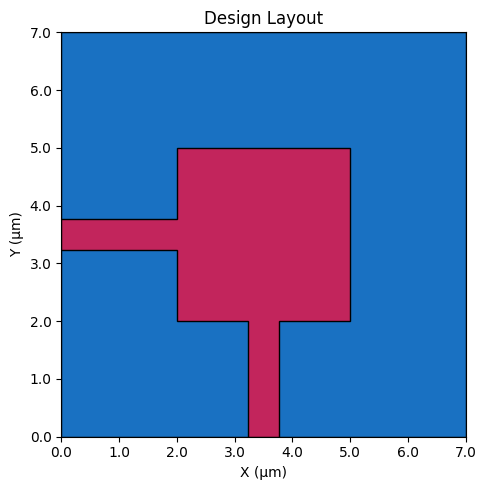

In [2]:
# Design & Materials
design = Design(width=W, height=H, material=Material(permittivity=N_CLAD**2))
design += Rectangle(position=(0, H/2-WG_W/2), width=W/2, height=WG_W, material=Material(permittivity=N_CORE**2))
design += Rectangle(position=(W/2-WG_W/2, 0), width=WG_W, height=H/2, material=Material(permittivity=N_CORE**2))

# Optimization Region (added as placeholder)
opt_region = Rectangle(position=(W/2-1.5*µm, H/2-1.5*µm), width=3*µm, height=3*µm, material=Material(permittivity=N_CORE**2))
design += opt_region

design.show()

The square at the center of this 2D design will later be used to create the region within which we optimize the topology using the adjoint method.

---

Next, we define our sources. We need a mode source at the input on the left and one at the bottom for the forward and adjoint simulations respectively. We use TM polarization where the fields $E_z$, $H_x$, and $H_y$ are non-zero.

The `time` array defines every time step of our simulations. We use a ramped cosine signal which ramps up and down smoothly to avoid scattering artifacts.

● Auto-selecting 2D meshing for effectively 2D design (depth=0)

Output()

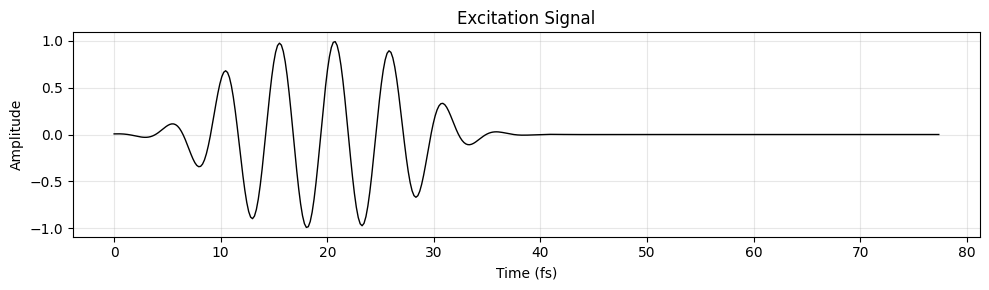

In [3]:
# Discretize the design
grid = design.rasterize(DX)

# Discrete time & signal
time = np.arange(0, 15*WL/LIGHT_SPEED, DT)
signal = ramped_cosine(time, 1, LIGHT_SPEED/WL, ramp_duration=3.5*WL/LIGHT_SPEED, t_max=time[-1]/2)

# Plot the signal
plt.figure(figsize=(10, 3))
plt.plot(time * 1e15, signal, 'k-', linewidth=1)
plt.xlabel('Time (fs)')
plt.ylabel('Amplitude')
plt.title('Excitation Signal')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Sources
src_fwd = ModeSource(None, center=(1.0*µm, H/2), width=WG_W*4, wavelength=WL, pol="tm", signal=signal, direction="+x")
src_adj = ModeSource(None, center=(W/2, 1.0*µm), width=WG_W*4, wavelength=WL, pol="tm", signal=signal, direction="+y")

Output()

Starting Topology Optimization (40 steps)...


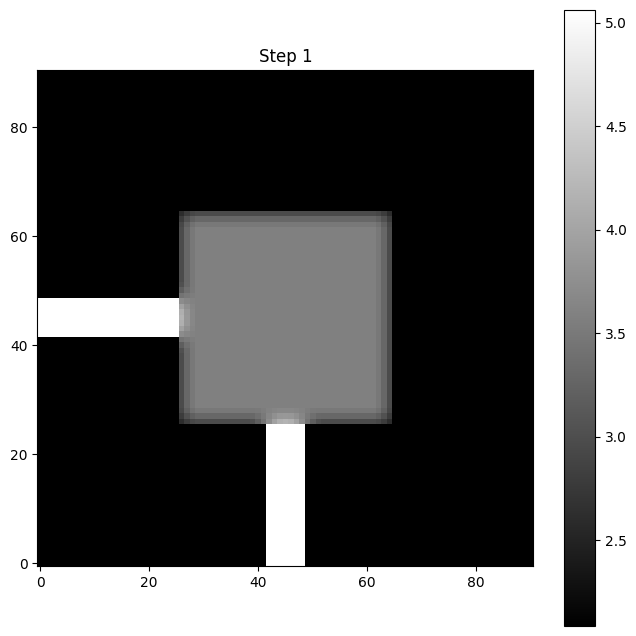

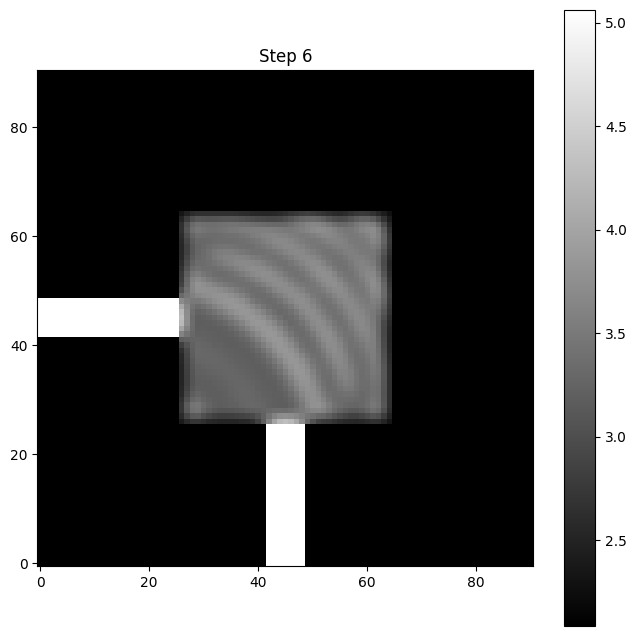

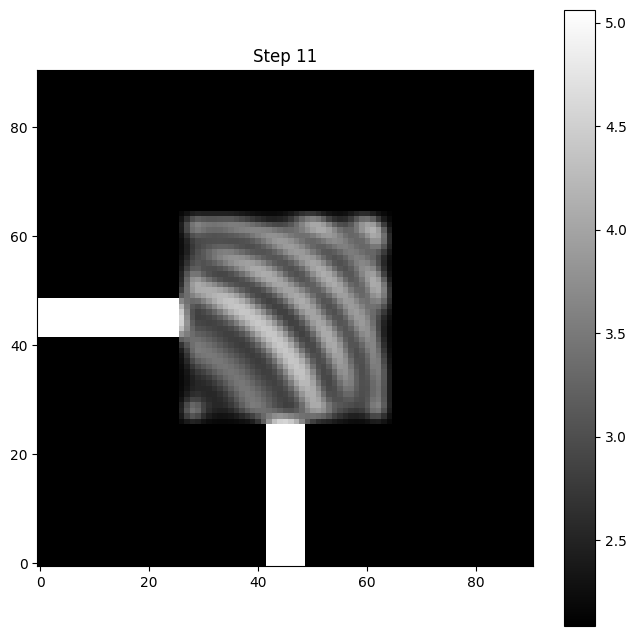

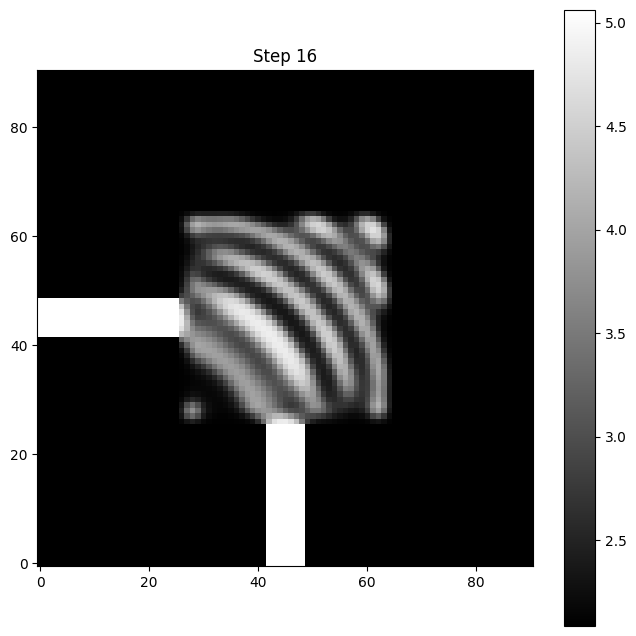

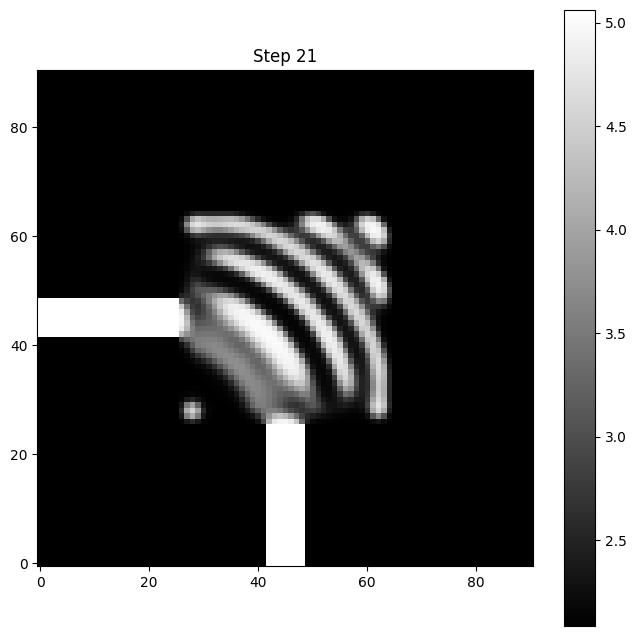

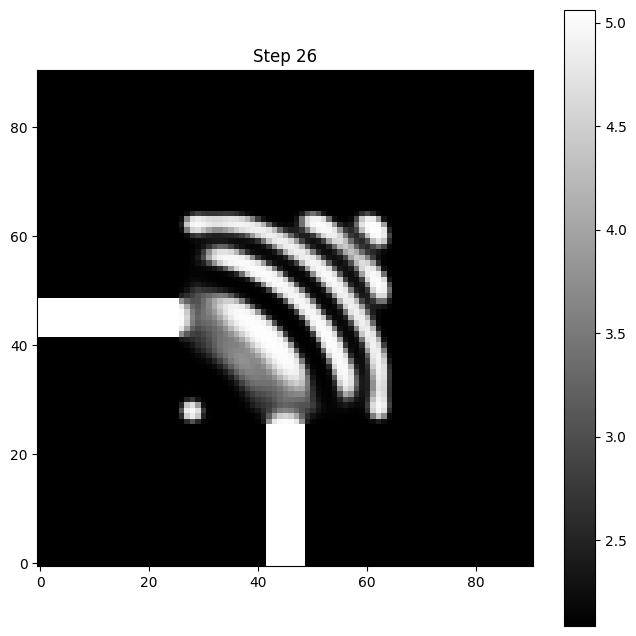

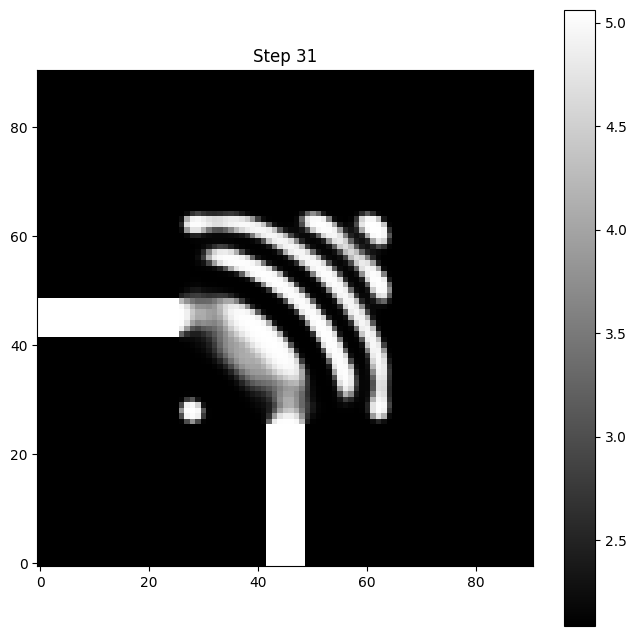

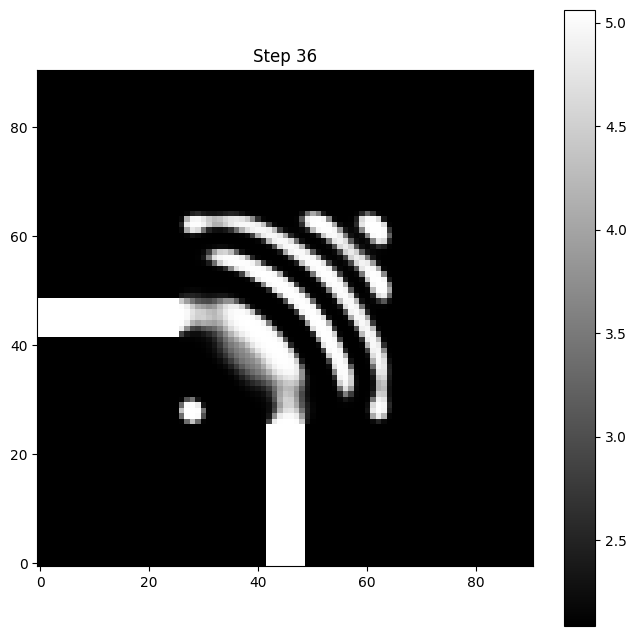

 Step 40: Obj=9.65e+01 (Trans=96.5% | Fwd=96.5% Bwd=96.5%) | Mat=35.0% | MaxUp=1.75e-02
Optimization Complete. Final Transmission: 96.5%


In [4]:
# Rasterize once to get grid and mask
mask = create_optimization_mask(grid, opt_region)

opt = TopologyManager(
    design=design,
    region_mask=mask,
    resolution=DX,
    learning_rate=0.015,
    filter_radius=0.3*µm,       # Physical units: Controls minimum feature size AND boundary smoothness
    eps_min=N_CLAD**2,
    eps_max=N_CORE**2,
    beta_schedule=(1.0, 20.0),
    filter_type="conic",         # Use conic filter for geometric constraints
)

print(f"Starting Topology Optimization ({STEPS} steps)...")
base_eps = grid.permittivity.copy() # Store background (cladding)

# Track transmission history
transmission_history = []

for step in range(STEPS):
    # Update Design
    beta, phys_density = opt.update_design(step, STEPS)
    
    # Mix Density into Permittivity (Linear Interpolation)
    grid.permittivity[:] = base_eps
    grid.permittivity[mask] = opt.eps_min + phys_density[mask] * (opt.eps_max - opt.eps_min)
    
    # Forward Simulation (only output monitor)
    src_fwd.grid = grid # Update grid ref
    
    # Setup monitors for input and output power measurement
    monitor_input_flux = Monitor(design=grid, start=(1.5*µm, H/2-WG_W*2), end=(1.5*µm, H/2+WG_W*2), 
                           accumulate_power=True, record_fields=False)
    output_monitor_fwd = Monitor(design=grid, start=(W/2-WG_W*2, 1.5*µm), end=(W/2+WG_W*2, 1.5*µm),
                                 accumulate_power=True, record_fields=False)
    
    # Run forward simulation with output monitor
    sim_fwd = Simulation(grid, [src_fwd, monitor_input_flux, output_monitor_fwd], 
                        [PML(edges='all', thickness=1*µm)], time=time, resolution=DX)
    
    print(f"[{step+1}/{STEPS}] Forward Sim...", end="\r")
    results = sim_fwd.run(save_fields=['Ez'], field_subsample=2)
    
    # Extract field history and ensure NumPy arrays
    fwd_ez_history = [np.array(field) for field in results['fields']['Ez']] if results and 'fields' in results else []
    
    # Calculate transmission normalizing by measured input flux
    measured_input_energy = np.sum(monitor_input_flux.power_history) * DT
    measured_output_energy = np.sum(output_monitor_fwd.power_history) * DT
    if measured_input_energy <= 0: measured_input_energy = 1.0
    transmission_fwd = (np.abs(measured_output_energy) / np.abs(measured_input_energy) * 100.0)
    
    # Backward Simulation (with backward monitor at input location)
    src_adj.grid = grid
    
    monitor_back_flux = Monitor(design=grid, start=(W/2-WG_W*2, 1.5*µm), end=(W/2+WG_W*2, 1.5*µm),
                              accumulate_power=True, record_fields=False)
    backward_monitor = Monitor(design=grid, start=(1.5*µm, H/2-WG_W*2), end=(1.5*µm, H/2+WG_W*2),
                              accumulate_power=True, record_fields=False)
    
    sim_adj = Simulation(grid, [src_adj, monitor_back_flux, backward_monitor], 
                        [PML(edges='all', thickness=1*µm)], time=time, resolution=DX)
    
    adj_results = sim_adj.run(save_fields=['Ez'], field_subsample=2)
    adj_ez_history = [np.array(field) for field in adj_results['fields']['Ez']] if adj_results and 'fields' in adj_results else []
    
    # Calculate backward transmission normalizing by measured backward input flux
    measured_input_energy_back = np.sum(monitor_back_flux.power_history) * DT
    if measured_input_energy_back <= 0: measured_input_energy_back = 1.0
    
    output_energy_back = np.sum(backward_monitor.power_history) * DT
    transmission_back = (np.abs(output_energy_back) / np.abs(measured_input_energy_back) * 100.0)
    
    # Average bidirectional transmission
    transmission_pct = (transmission_fwd + transmission_back) / 2.0
    obj_val = transmission_pct
    
    opt.objective_history.append(obj_val)
    transmission_history.append(transmission_pct)
            
    # Compute Gradient (overlap of fwd and adj fields)
    grad_eps = compute_overlap_gradient(fwd_ez_history, adj_ez_history)
    grad_eps = np.array(grad_eps)

    # Material penalty gradient
    current_density = np.mean(phys_density[mask])
    grad_penalty = PENALTY_STRENGTH * (current_density - MAT_PENALTY)
    grad_eps[mask] -= grad_penalty

    # Total Objective for display
    penalty_val = PENALTY_STRENGTH * 0.5 * (current_density - MAT_PENALTY)**2
    total_obj = obj_val - penalty_val
    
    # Step Optimizer
    max_update = opt.apply_gradient(grad_eps, beta)
    
    mat_frac = np.mean(phys_density[mask])
    
    print(f" Step {step+1}: Obj={total_obj:.2e} (Trans={transmission_pct:.1f}% | Fwd={transmission_fwd:.1f}% Bwd={transmission_back:.1f}%) | Mat={mat_frac:.1%} | MaxUp={max_update:.2e}", end="\r")
    
    # Viz
    if step % 5 == 0:
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.permittivity.T, cmap='gray', origin='lower')
        plt.title(f'Step {step+1}')
        plt.colorbar()
        plt.show()

print(f"\nOptimization Complete. Final Transmission: {transmission_history[-1]:.1f}%")

## Plotting the Results

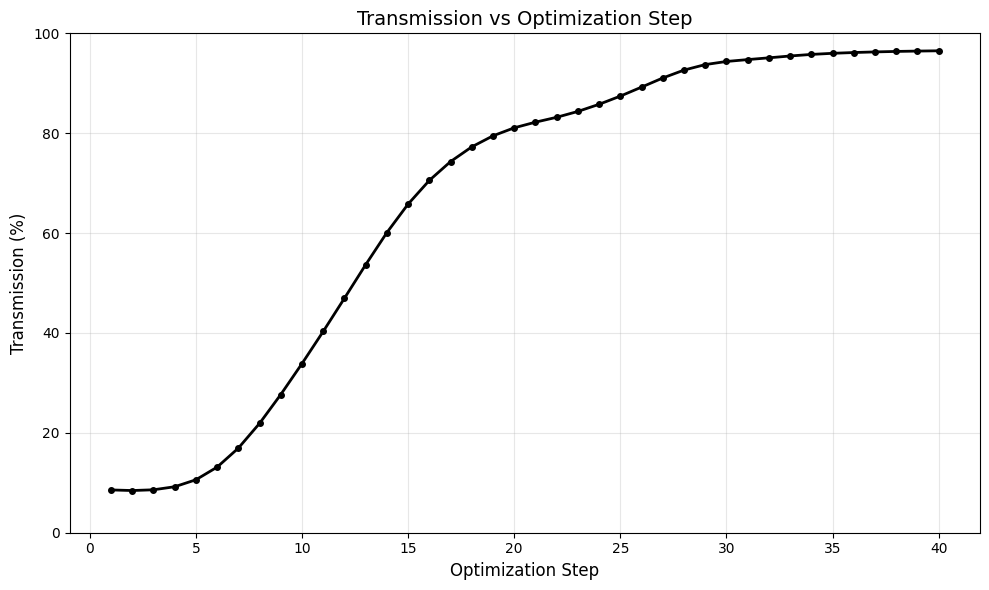

--- Running Final Frequency Sweep (1200-1800 nm) ---
Simulating Wavelength: 1.800 µm...
Sweep Complete.


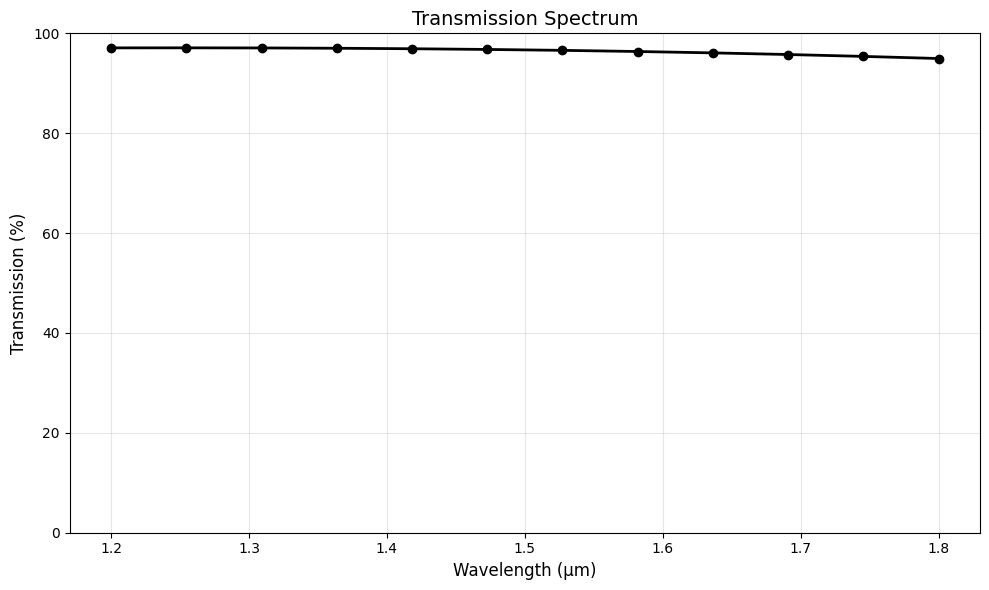

--- Generating Final Field Plot (1.55 µm) ---
Calculating energy flow...


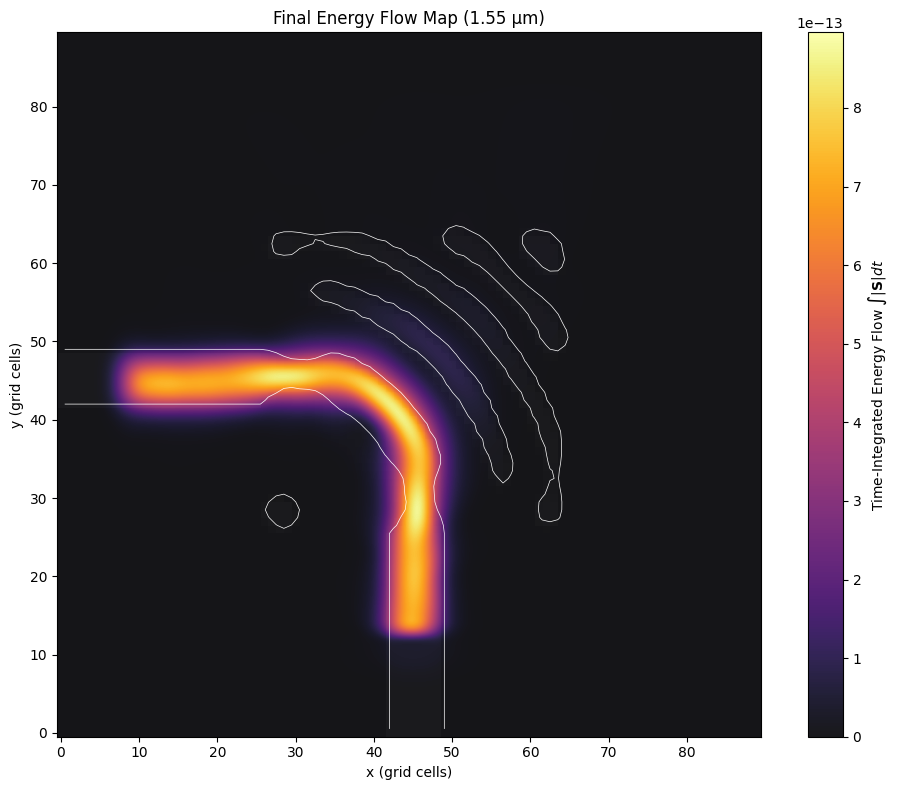

In [5]:
# Plot transmission vs step (as percentage)
plt.figure(figsize=(10, 6))
steps = np.arange(1, len(transmission_history) + 1)
plt.plot(steps, transmission_history, 'o-', linewidth=2, markersize=4, color='black')
plt.xlabel('Optimization Step', fontsize=12)
plt.ylabel('Transmission (%)', fontsize=12)
plt.title('Transmission vs Optimization Step', fontsize=14)
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Final Verification & Visualization ---
# Frequency sweep to verify broadband performance
print("--- Running Final Frequency Sweep (1200-1800 nm) ---")

wavelengths = np.linspace(1.2*µm, 1.8*µm, 12)
sweep_transmission = []

time_sweep = np.arange(0, 15*WL/LIGHT_SPEED, DT)

for i, wl_val in enumerate(wavelengths):
    print(f"Simulating Wavelength: {wl_val/µm:.3f} µm...", end="\r")
    
    signal_sweep = ramped_cosine(time, 1, LIGHT_SPEED/WL, ramp_duration=3.5*WL/LIGHT_SPEED, t_max=time[-1]/2)
    
    src_sweep = ModeSource(grid, center=(1.0*µm, H/2), width=WG_W*4, wavelength=wl_val, pol="tm", signal=signal_sweep, direction="+x")
    src_sweep._jz_profile = None 
    src_sweep.initialize(grid.permittivity, DX)
    
    mon_in = Monitor(design=grid, start=(1.5*µm, H/2-WG_W*2), end=(1.5*µm, H/2+WG_W*2), accumulate_power=True)
    mon_out = Monitor(design=grid, start=(W/2-WG_W*2, 1.5*µm), end=(W/2+WG_W*2, 1.5*µm), accumulate_power=True)
    
    sim_sweep = Simulation(grid, [src_sweep, mon_in, mon_out], 
                           [PML(edges='all', thickness=1*µm)], time=time_sweep, resolution=DX)
    
    sim_sweep.run(save_fields=[], field_subsample=10)
    
    in_E = np.sum(mon_in.power_history) * DT
    out_E = np.sum(mon_out.power_history) * DT
    trans = (np.abs(out_E) / np.abs(in_E) * 100.0) if np.abs(in_E) > 0 else 0.0
    sweep_transmission.append(trans)

print(f"\nSweep Complete.")

# Plot Frequency Sweep
plt.figure(figsize=(10, 6))
plt.plot(wavelengths/µm, sweep_transmission, '-o', linewidth=2, color='black')
plt.xlabel('Wavelength (µm)', fontsize=12)
plt.ylabel('Transmission (%)', fontsize=12)
plt.title('Transmission Spectrum', fontsize=14)
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# --- Final Visualization (Center Wavelength) ---
print("--- Generating Final Field Plot (1.55 µm) ---")
signal_final = ramped_cosine(time, 1, LIGHT_SPEED/WL, ramp_duration=3.5*WL/LIGHT_SPEED, t_max=time[-1]/2)
src_final = ModeSource(grid, center=(1.0*µm, H/2), width=WG_W*4, wavelength=WL, pol="tm", signal=signal_final, direction="+x")
src_final.initialize(grid.permittivity, DX)

mon_in_final = Monitor(design=grid, start=(1.5*µm, H/2-WG_W*2), end=(1.5*µm, H/2+WG_W*2), accumulate_power=True)
mon_out_final = Monitor(design=grid, start=(W/2-WG_W*2, 1.5*µm), end=(W/2+WG_W*2, 1.5*µm), accumulate_power=True)

sim_final = Simulation(grid, [src_final, mon_in_final, mon_out_final], [PML(edges='all', thickness=1*µm)], time=time_sweep, resolution=DX)
results_final = sim_final.run(save_fields=['Ez', 'Hx', 'Hy'], field_subsample=1)

# Calculate final transmission
in_E = np.sum(mon_in_final.power_history) * DT
out_E = np.sum(mon_out_final.power_history) * DT
trans_final = (np.abs(out_E) / np.abs(in_E) * 100.0) if np.abs(in_E) > 0 else 0.0

print("Calculating energy flow...")
Ez_t = np.array(results_final['fields']['Ez'])
Hx_t = np.array(results_final['fields']['Hx'])
Hy_t = np.array(results_final['fields']['Hy'])

min_x = min(Ez_t.shape[1], Hx_t.shape[1], Hy_t.shape[1])
min_y = min(Ez_t.shape[2], Hx_t.shape[2], Hy_t.shape[2])

Ez_c = Ez_t[:, :min_x, :min_y]
Hx_c = Hx_t[:, :min_x, :min_y]
Hy_c = Hy_t[:, :min_x, :min_y]

Sx_t = -Ez_c * Hy_c
Sy_t = Ez_c * Hx_c
S_mag_t = np.sqrt(Sx_t**2 + Sy_t**2)
energy_flow = np.sum(S_mag_t, axis=0) * DT

plt.figure(figsize=(10, 8))
perm_c = grid.permittivity[:min_x, :min_y]
plt.imshow(perm_c.T, cmap='gray', origin='lower', alpha=0.2)
plt.contour(perm_c.T, levels=[(N_CORE**2 + N_CLAD**2)/2], colors='white', linewidths=0.5, origin='lower')
im = plt.imshow(energy_flow.T, cmap='inferno', origin='lower', alpha=0.9, interpolation='bicubic')
plt.colorbar(im, label=r'Time-Integrated Energy Flow $\int |\mathbf{S}| dt$')
plt.title(f'Final Energy Flow Map (1.55 µm)')
plt.xlabel('x (grid cells)')
plt.ylabel('y (grid cells)')
plt.tight_layout()
plt.show()